<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Vridhi_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
* #### PromoInterval1/2/3 - describes the occurance of the promo2 in the months of 'Jan,Apr,July,Oct'/'Feb,May,Aug,Nov'/'March,June,Sep,dec' respectively where 1= the occurance and 0= not occuring

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
path = '/content/drive/MyDrive/Capstone Project 2/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [172]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [173]:
store_data_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [174]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [207]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval1             1115 non-null   int64  
 10  PromoInterval2             1115 non-null   int64  
 11  PromoInterval3             1115 non-null   int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 104.7+ KB


In [176]:
store_df['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [177]:
store_df['Promo2SinceWeek'].fillna(0,inplace=True)

In [178]:
store_df['Promo2SinceYear'].fillna(0,inplace=True)

In [179]:
store_df['CompetitionDistance'].fillna(0,inplace=True)

In [180]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [181]:
def Promo_interval1(row):
  if (row['PromoInterval']== 'Jan,Apr,Jul,Oct'):
    val = 1
  else:
    val =0
  return val

In [182]:
def Promo_interval2(row):
  if (row['PromoInterval']== 'Feb,May,Aug,Nov'):
    val = 1
  else:
    val =0
  return val

In [186]:
def Promo_interval3(row):
  if (row['PromoInterval']== 'Mar,Jun,Sept,Dec'):
    val = 1
  else:
    val =0
  return val

In [183]:
store_df['PromoInterval1']= store_df.apply(Promo_interval1,axis=1)

In [184]:
store_df['PromoInterval2']=store_df.apply(Promo_interval2,axis=1)

In [187]:
store_df['PromoInterval3']=store_df.apply(Promo_interval3,axis=1)

In [189]:
store_df.drop(labels='PromoInterval',axis=1,inplace=True)

In [190]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,1,0,0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,1,0,0
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,0,0


In [191]:
store_df['PromoInterval1'].value_counts()

0    780
1    335
Name: PromoInterval1, dtype: int64

In [201]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3
count,1115.00000,1115.000000,761.000000,761.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5390.358744,7.224704,2008.668857,0.512108,12.083408,1030.239462,0.300448,0.116592,0.095067
std,322.01708,7657.973705,3.212348,6.195983,0.500078,15.542241,1006.038782,0.458659,0.321077,0.293439
min,1.00000,0.000000,1.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,710.000000,4.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,2320.000000,8.000000,2010.000000,1.000000,1.000000,2009.000000,0.000000,0.000000,0.000000
75%,836.50000,6875.000000,10.000000,2013.000000,1.000000,22.000000,2012.000000,1.000000,0.000000,0.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,1.000000,1.000000,1.000000


In [202]:
n=['Store','CompetitionDistance','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3']

In [203]:
numeric_features= store_df[n]

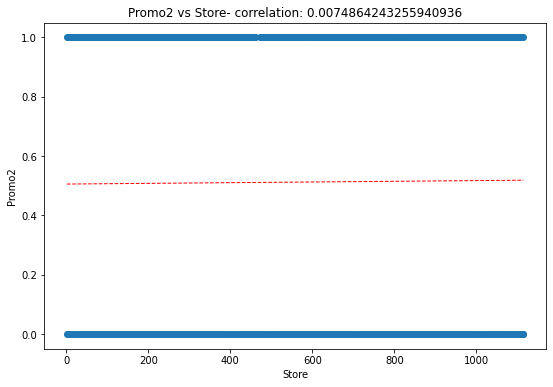

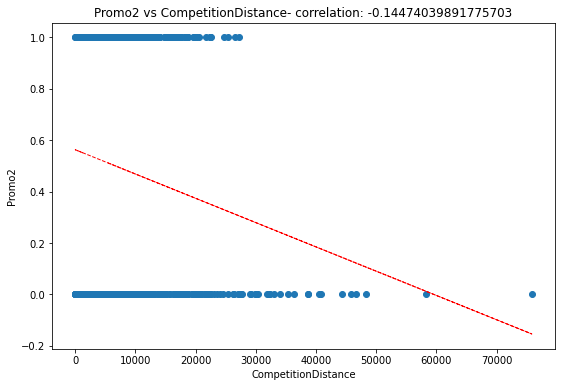

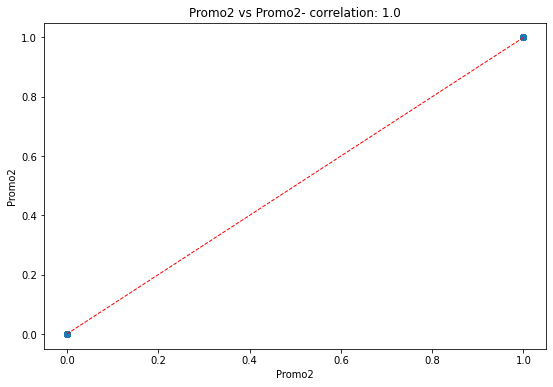

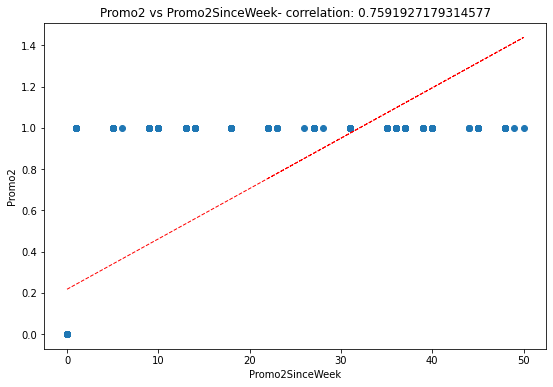

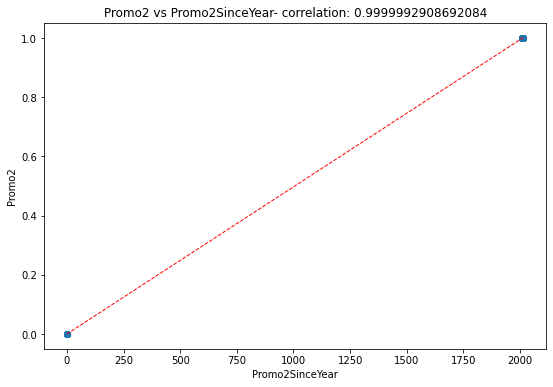

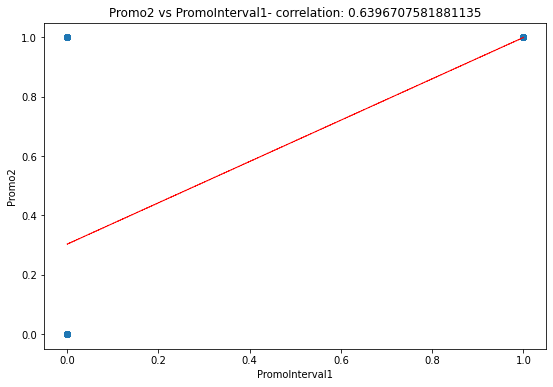

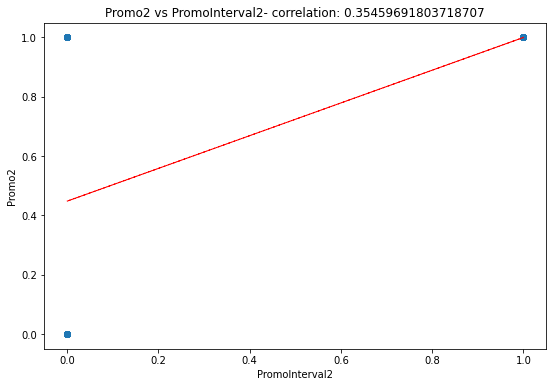

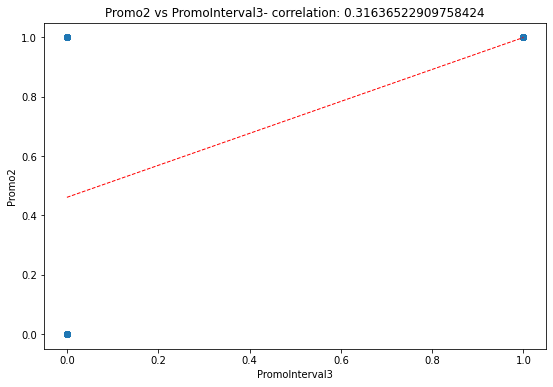

In [205]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = store_df[col]
    label = store_df['Promo2']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Promo2')
    ax.set_title('Promo2 vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(store_df[col], store_df['Promo2'], 1)
    y_hat = np.poly1d(z)(store_df[col])

    plt.plot(store_df[col], y_hat, "r--", lw=1)

plt.show()

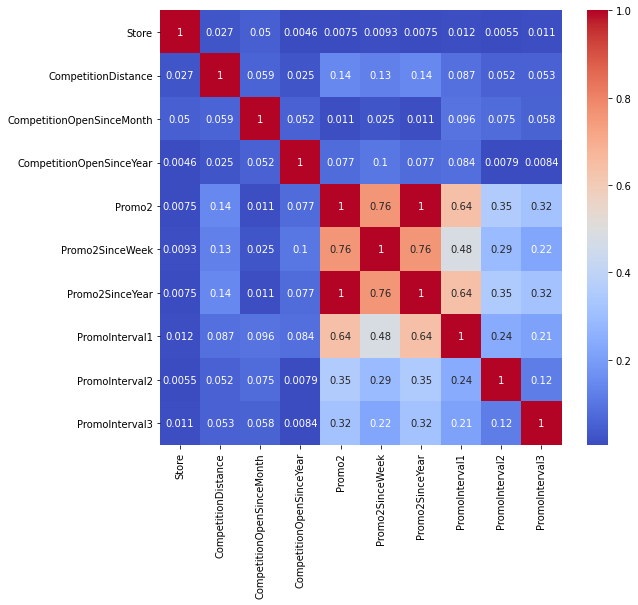

In [206]:
plt.figure(figsize=(9,8))
correlation = store_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')